# Dati nazionali generali

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

from utility.metrics import rt_rki

# Aggiornare con il proprio path locale
#prociv_repo_dir = "/media/michele/DATA-2/Covid/prociv-covid"
prociv_repo_dir = "/home/michele/Covid/prociv-covid"

Lettura dati Istat sulla popolazione

In [2]:
popolazione = pd.read_csv(os.path.join("dati_aggiuntivi", "popolazione_istat_2020.csv"))
popolazione_nazionale = int(popolazione[popolazione["Zona"] == "Italia"]["Popolazione"])
popolazione.head()

,Zona,Popolazione
0,Italia,59641488
1,Piemonte,4311217
2,Torino,2230946
3,Vercelli,169390
4,Novara,364980


In [3]:
andamento_nazionale_csv = os.path.join(prociv_repo_dir, "dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [4]:
andamento_nazionale = pd.read_csv(andamento_nazionale_csv, parse_dates=[0])
andamento_nazionale['deceduti_giornalieri'] = andamento_nazionale.deceduti.diff()
andamento_nazionale.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,deceduti_giornalieri
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,0,221,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,93,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,78,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,250,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,238,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [5]:
andamento_nazionale.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'deceduti_giornalieri'],
      dtype='object')

In [6]:
f"Aggiornato al {andamento_nazionale['data'].max()}"

'Aggiornato al 2021-05-08 17:00:00'

## Smoothing e aggregazione

Smoothing 7, periodicità settimanale per i positivi

In [7]:
andamento_nazionale['nuovi_positivi_mov_avg'] = andamento_nazionale['nuovi_positivi'].rolling(7).mean()

Smoothing necessario anche per i deceduti, si riusa 7 per comodità

In [8]:
andamento_nazionale['deceduti_giornalieri_mov_avg'] = andamento_nazionale['deceduti_giornalieri'].rolling(7).mean()

Nuovi positivi settimanali per 100 000 abitanti

In [9]:
andamento_nazionale['nuovi_positivi_settimanali_centomila_abitanti'] = andamento_nazionale['nuovi_positivi'].rolling(7).sum() * 100000 / popolazione_nazionale

Rt formula RKI (https://covid19.infn.it/sommario/rt-info.html)

In [10]:
andamento_nazionale['rt_rki'] = rt_rki(andamento_nazionale['nuovi_positivi_mov_avg'])

## Andamento dall'inizio

<IPython.core.display.Javascript object>


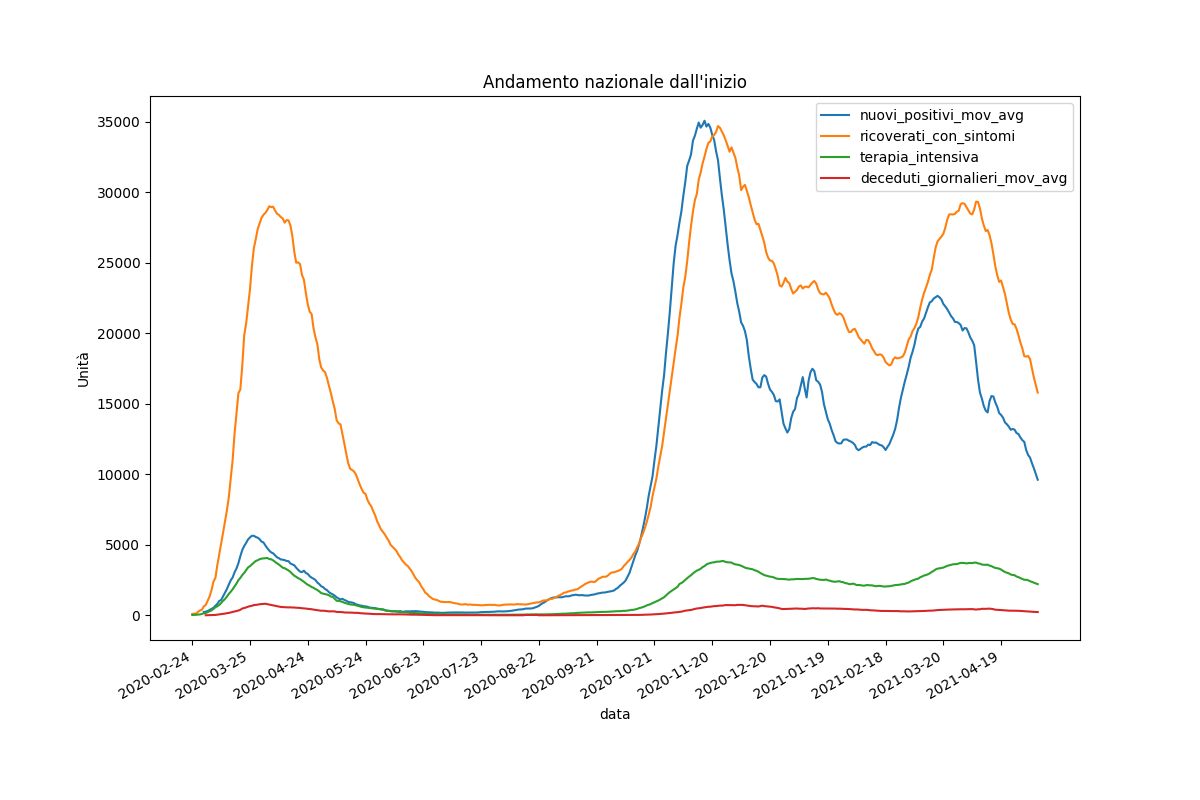

In [11]:
sampling_x = [data for ix, data in enumerate(andamento_nazionale["data"]) if ix % 30 == 0]
andamento_nazionale.plot(
    x="data",
    xticks=sampling_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento nazionale dall'inizio",
    ylabel="Unità",
    figsize=[12, 8]
);

## Andamento con filtro data

Analisi dati a partire dalla seconda ondata dove si ha maggiore copertura e affidabilità nella raccolta dati

In [12]:
primo_ottobre = "2020-10-01 18:00:00"
inizio_zone_di_colore = "2020-11-06 18:00:00"  # DPCM 3 novembre 2020
filtro_data = primo_ottobre

### Tutte le metriche

<IPython.core.display.Javascript object>


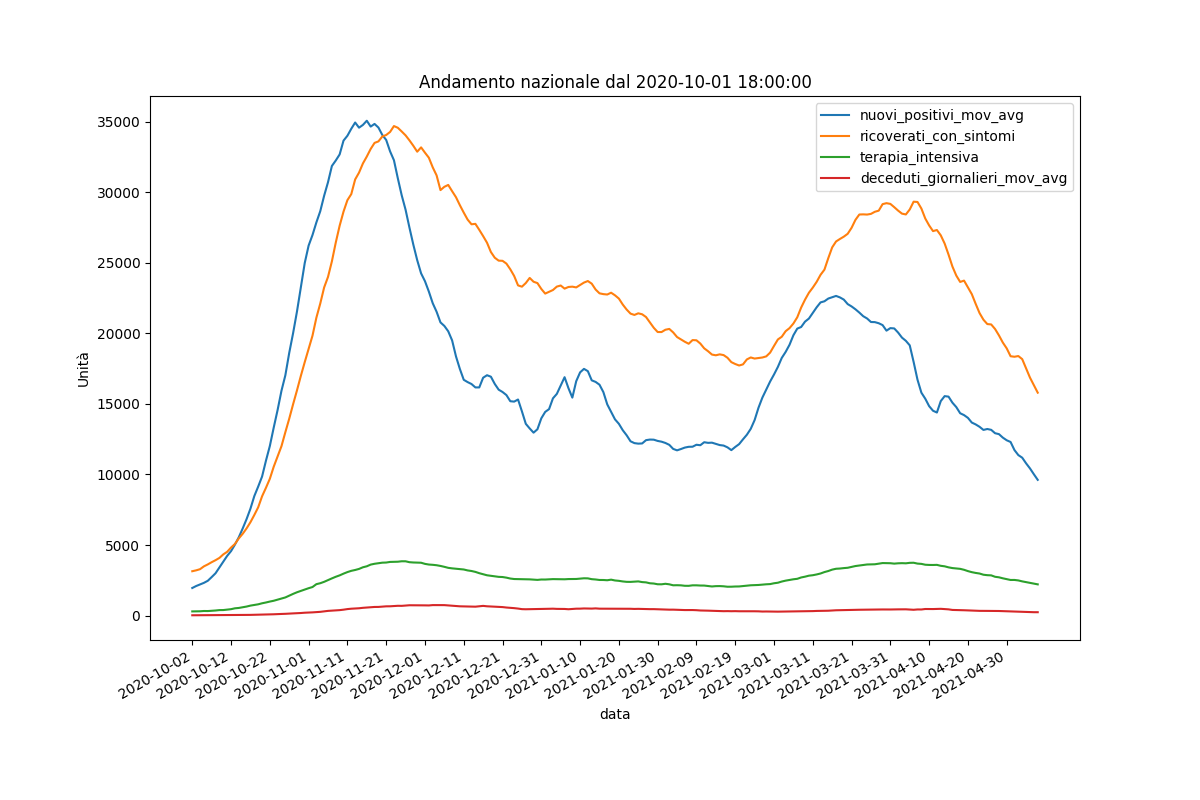

In [13]:
andamento_nazionale_filtrato = andamento_nazionale[andamento_nazionale["data"] >= filtro_data]
sampling_filtrato_x = [data for ix, data in enumerate(andamento_nazionale_filtrato["data"]) if ix % 10 == 0]
andamento_nazionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento nazionale dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Nuovi positivi settimanali per centomila abitanti

Limiti utilizzati anche per il cambio colore qui semplificato:
- Sotto i 50 per 100 000 a settimana -> OK (limite zona bianca)
- Sopra i 250 -> Rosso

In [14]:
inizio_soglia_allerta_incidenza = 50
limite_soglia_allerta_incidenza = 250

<IPython.core.display.Javascript object>


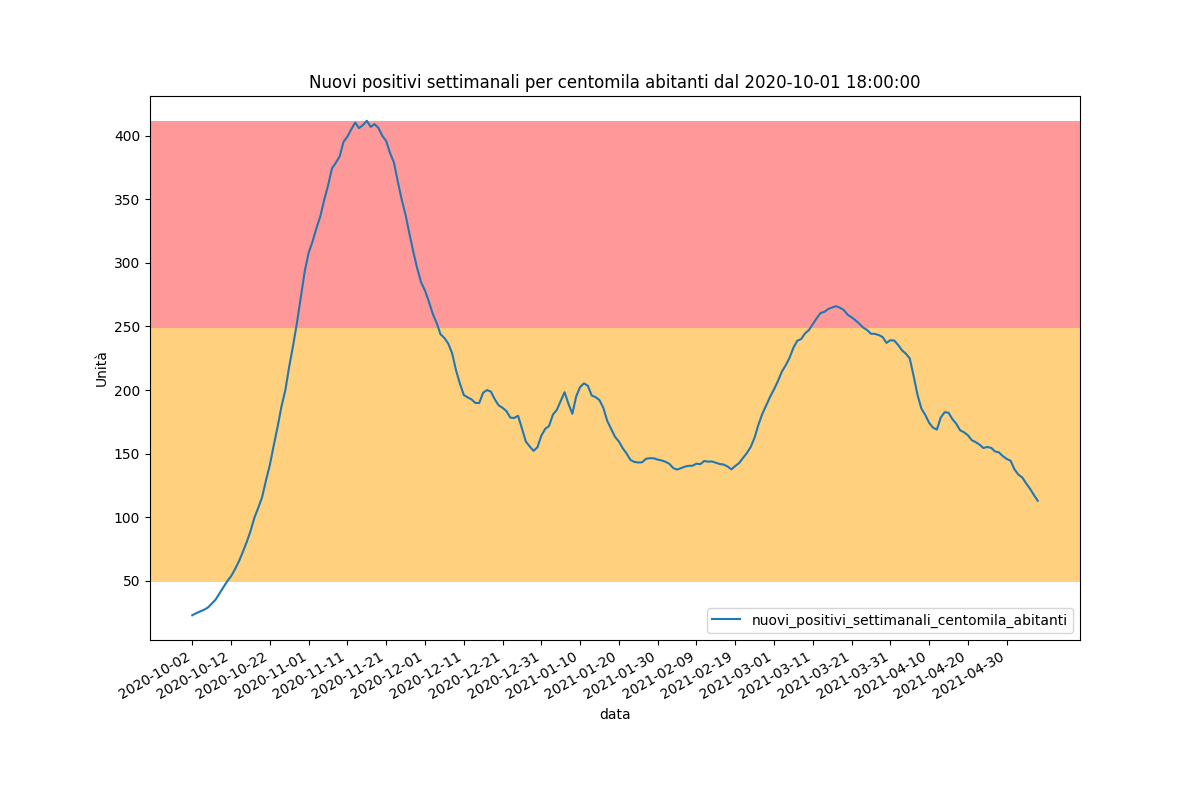

In [15]:
max_y = andamento_nazionale_filtrato["nuovi_positivi_settimanali_centomila_abitanti"].max()
sampling_y = range(0, int(max_y), 50)
andamento_nazionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    yticks=sampling_y,
    y=["nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Nuovi positivi settimanali per centomila abitanti dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
)
plt.axhspan(inizio_soglia_allerta_incidenza - 1, min(max_y, limite_soglia_allerta_incidenza - 1), facecolor='orange', alpha=0.5)
if max_y >= limite_soglia_allerta_incidenza:
    plt.axhspan(limite_soglia_allerta_incidenza - 1, max_y, facecolor='r', alpha=0.4)
plt.show()

### Terapia intensiva e decessi

<IPython.core.display.Javascript object>


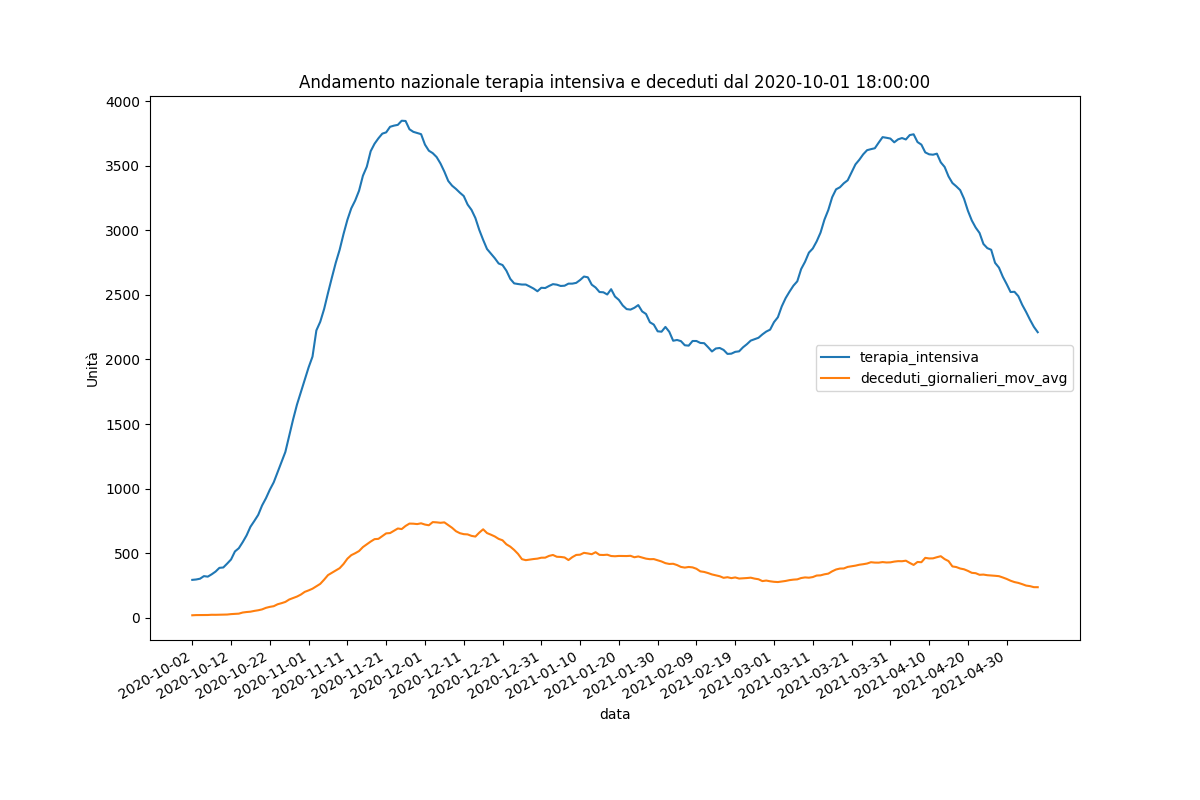

In [16]:
andamento_nazionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento nazionale terapia intensiva e deceduti dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Indice di trasmissibilità Rt

Limiti utilizzati anche per il cambio colore (limite variato nel tempo):
- Tra 1.0 e 1.25 zona arancione
- Sopra 1.25 zona rossa

In [17]:
soglia_rt_arancione = 1.0
soglia_rt_rossa = 1.25

<IPython.core.display.Javascript object>


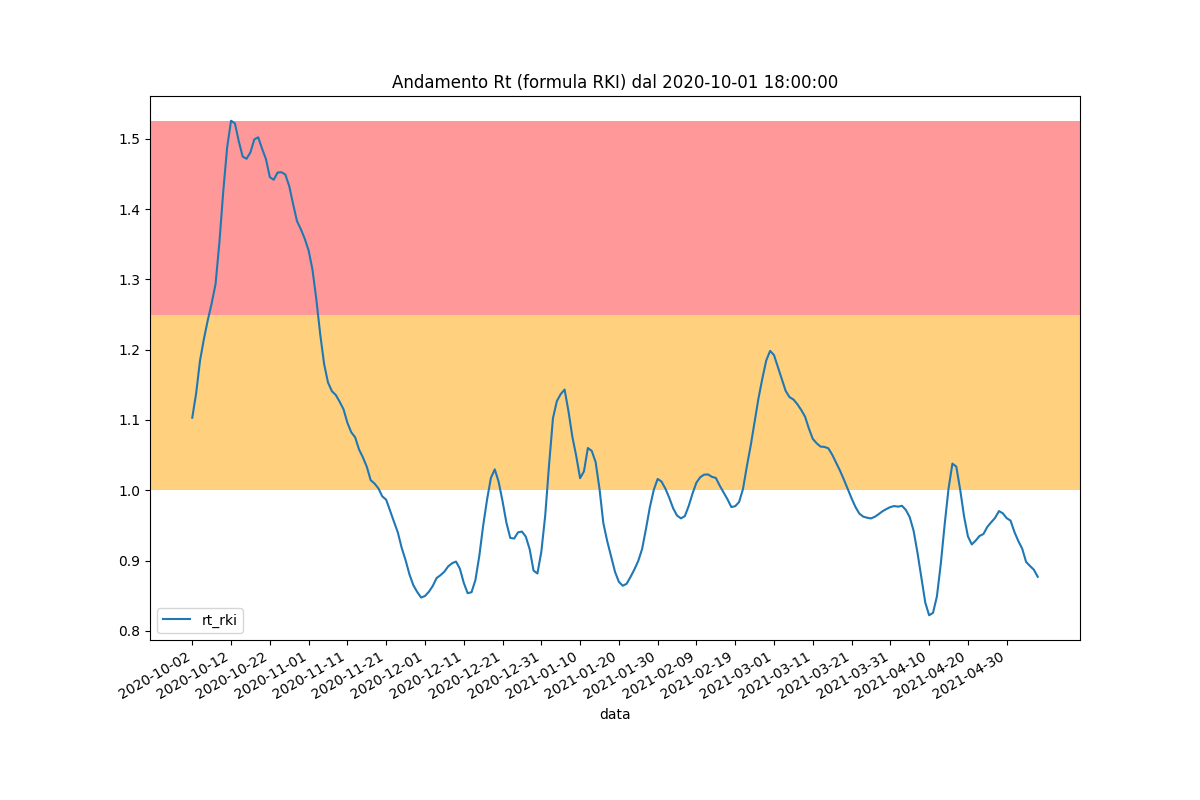

In [18]:
max_y_rt = andamento_nazionale_filtrato["rt_rki"].max()
andamento_nazionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["rt_rki"],
    title=f"Andamento Rt (formula RKI) dal {filtro_data}",
    figsize=[12, 8]
)
plt.axhspan(soglia_rt_arancione,  min(max_y_rt, soglia_rt_rossa), facecolor='orange', alpha=0.5)
if max_y_rt >= soglia_rt_rossa:
    plt.axhspan(soglia_rt_rossa, max_y_rt, facecolor='r', alpha=0.4)
plt.show()

### Normalizzazione

In [19]:
colonne_da_normalizzare = ["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg", "rt_rki"]
for colonna_norm in colonne_da_normalizzare:
    andamento_nazionale_filtrato[colonna_norm + "_norm"] = \
        (andamento_nazionale_filtrato[colonna_norm] - andamento_nazionale_filtrato[colonna_norm].min()) / \
        (andamento_nazionale_filtrato[colonna_norm].max() - andamento_nazionale_filtrato[colonna_norm].min())

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


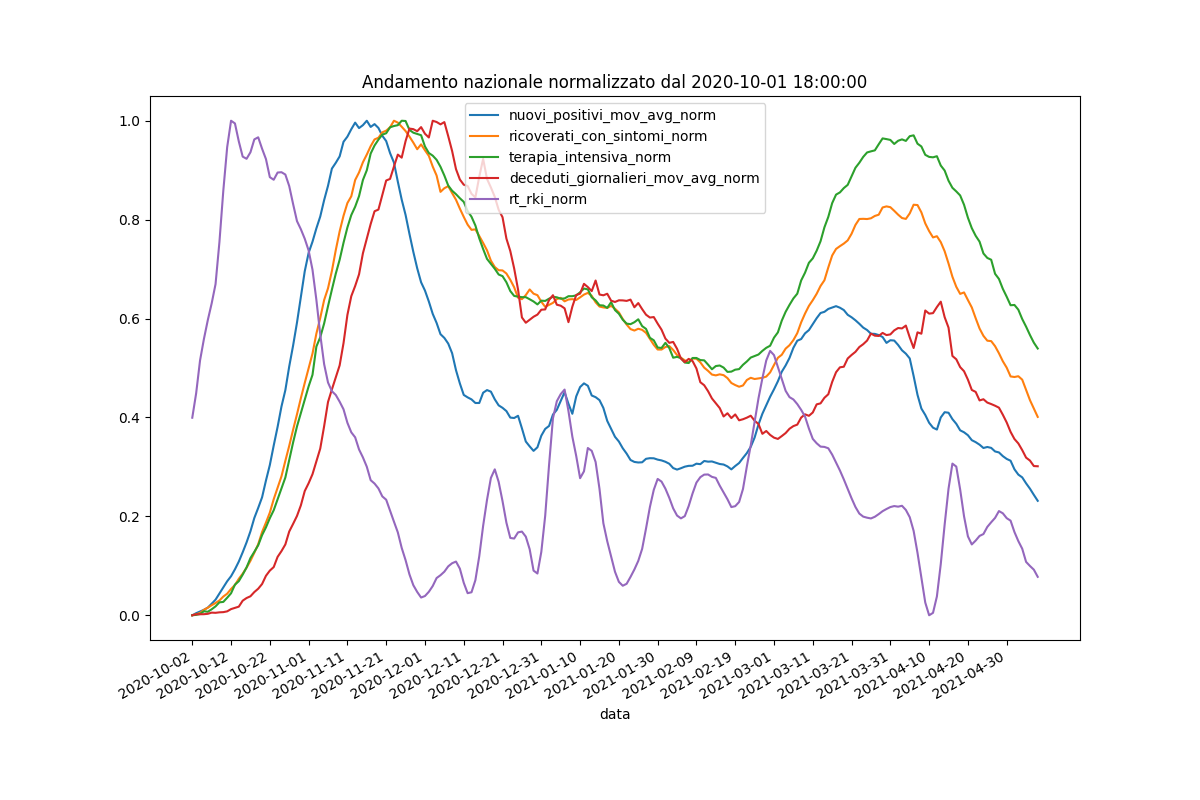

In [20]:
andamento_nazionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg_norm", "ricoverati_con_sintomi_norm", "terapia_intensiva_norm", "deceduti_giornalieri_mov_avg_norm", "rt_rki_norm"],
    title=f"Andamento nazionale normalizzato dal {filtro_data}",
    figsize=[12, 8]
);